In [2]:
import os

# Check current working directory
print("Current directory:", os.getcwd())

# Change directory
os.chdir("/lab/deasylab3/")

# Verify change
print("New directory:", os.getcwd())

import os
import numpy as np
import pandas as pd
import tiffslide
from PIL import Image
import matplotlib.pyplot as plt
data_path = '/lab/deasylab3/Jung/Data/Shared_Data/TCGA_Lung/pathology-slides/'
out_dir = "/lab/deasylab3/Himangi/psg/"

Current directory: /cluster/home/srivash/venvs/Mussel/path_gene_multimodal
New directory: /lab/deasylab3


In [3]:
image_files = os.listdir(data_path)

In [16]:
wsi_path = data_path + image_files[68]

In [17]:
classes = [
  "Tumor epithelium",
  "Tumor-associated stroma (desmoplastic stroma)",
  "Normal alveolar parenchyma",
  "Bronchial epithelium / cartilage",
  "Necrosis",
  "Hemorrhage / blood",
  "Vessel endothelium",
  "Lymphoid aggregate / TLS",
  "Adipose",
  "Background / artifact"
]


In [18]:
classes = [ "Tumor epithelium",
  "Tumor-associated stroma (desmoplastic stroma)",
 "Vessel endothelium",
  "Necrosis",
  "Lymphoid aggregate / TLS",
]

In [19]:
def show_tiff_thumbnail(tif_path, size=None):
    """
    Display a thumbnail of a TIF whole-slide image using tiffslide.
    
    Parameters:
        tif_path (str): Path to the .tif file
        size (tuple or None): (width, height) for a fixed-size thumbnail.
                              If None, smallest slide level is used.
    """
    slide = tiffslide.TiffSlide(tif_path)

    if size is None:
        # Use smallest resolution level
        level = slide.level_count - 1
        thumb = slide.read_region(
            location=(0, 0),
            level=level,
            size=slide.level_dimensions[level]
        )
    else:
        # Use tiffslide's built-in thumbnail scaler
        thumb = slide.get_thumbnail(size=size)

    plt.figure(figsize=(12, 12))
    plt.imshow(thumb)
    plt.axis("off")
    plt.show()


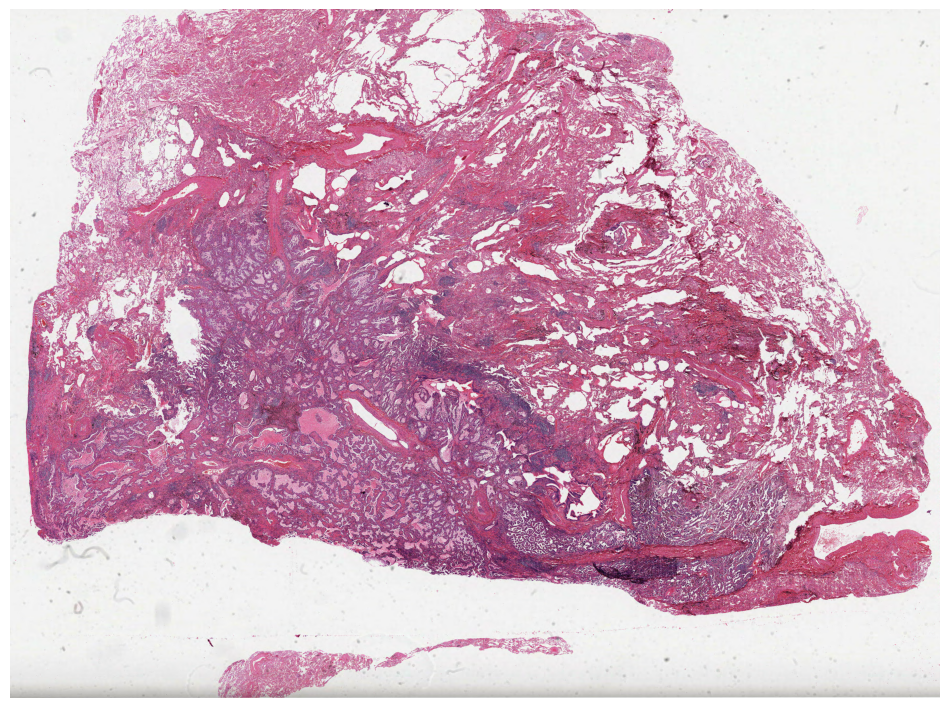

In [20]:
show_tiff_thumbnail(wsi_path)

In [21]:
import sys
sys.path.append("/cluster/home/srivash/venvs/Mussel/path_gene_multimodal")

from tiling import *
from extract_embedding_from_tiles import *
from create_embedding import *
from find_annotation_from_embedding import *
from load_annotation_with_coordinates import *
from create_and_overlay_polygon_from_prediction import*


In [22]:
run_tessellation(wsi_path,out_dir)

2025-12-05 12:13:25.580 | INFO     | mussel.utils.segment:segment_tissue:273 - slide_mpp: 0.252
2025-12-05 12:13:25.581 | DEBUG    | mussel.utils.segment:get_native_size:182 - desired_mpp: 0.500, slide_mpp: 0.252, mpp scale: 1.984
2025-12-05 12:13:25.581 | DEBUG    | mussel.utils.segment:get_native_size:182 - desired_mpp: 0.500, slide_mpp: 0.252, mpp scale: 1.984
2025-12-05 12:13:25.582 | INFO     | mussel.utils.segment:segment_tissue:277 - native_step_size: 508
2025-12-05 12:13:25.583 | INFO     | mussel.utils.segment:segment_tissue:278 - native_patch_size: 508
2025-12-05 12:13:26.895 | INFO     | mussel.utils.segment:segment_tissue:334 - Creating patches for: TCGA-78-7152-01Z-00-DX1.a04f9d84-3304-402c-9c0c-f64545c14781 ...
2025-12-05 12:13:26.896 | INFO     | mussel.utils.segment:segment_tissue:340 - Total number of contours: 2
2025-12-05 12:13:28.879 | INFO     | mussel.utils.segment:segment_tissue:345 - Total number of patches: 22850
2025-12-05 12:13:29.166 | INFO     | mussel.util

Tessellation complete! Results saved in /lab/deasylab3/Himangi/psg/TCGA-78-7152-01Z-00-DX1.a04f9d84-3304-402c-9c0c-f64545c14781


'/lab/deasylab3/Himangi/psg/TCGA-78-7152-01Z-00-DX1.a04f9d84-3304-402c-9c0c-f64545c14781'

In [23]:
run_extract_features_for_tessellation(
    wsi_path,
    base_output_dir=out_dir,
    model_type="CLIP",
    use_gpu=True,
    batch_size=128,
)

2025-12-05 12:37:43.136 | INFO     | mussel.cli.extract_features:main:217 - loading model checkpoint


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
class_pt = run_create_class_embeddings(classes, wsi_path, out_dir)

In [ ]:
# 4) Annotate tiles (pixel coordinates, classes in a  CSV))
csv_path = run_annotation_for_extracted_features(
    wsi_path,
    class_embedding_pt_path=class_pt,
    classes=classes,
    base_output_dir=out_dir,
)

In [ ]:
df = load_annotations_with_coords(wsi_path,classes, base_output_dir=out_dir)
print("Annotations_df:", df)

In [ ]:
features = build_polygons_for_all_classes(
    df, classes, tile_w=None, tile_h=None, priorities=classes,
     smooth_radius_tiles=1.0, blur_sigma=None, area_min_tiles=3, simplify_frac=0.2,
     min_polygon_area_px=3*565*565,
 )

In [ ]:
export_geojson(
    features=features,
    wsi_path=wsi_path,
    base_output_dir=out_dir,
    output_pt_path=None,  # optional override
)


In [ ]:
svs_path = wsi_path
thumb, sx, sy, _ = load_svs_thumbnail(svs_path, size=(2000, 2000))  # or None

# 2) Scale geometries from level-0 pixels → thumbnail pixels
#    Your 'features' geometries are in level-0 pixel coords (from the pipeline).
features_thumb = []
for f in features:
    g_thumb = scale_geometry_to_thumb(f["geometry"], sx, sy)
    features_thumb.append({"class": f["class"], "geometry": json.loads(json.dumps(g_thumb.__geo_interface__))})


# features should already be in thumbnail coords
out_path = plot_overlays_all_classes(
    thumb,
    features_thumb,
    wsi_path=wsi_path,
    base_output_dir=out_dir,
    show=True
)

saved = plot_overlays_per_class(
    thumb,
    features_thumb,
    wsi_path=wsi_path,
    base_output_dir=out_dir
)